Study of following gist code  
https://gist.github.com/gyu-don/f7af13e32f9b18010c75ffdb825f97f0

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import collections
from blueqat import Circuit, BlueqatGlobalSetting
from blueqat.pauli import I, X, Y, Z
import torch
import torchvision

In [2]:
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))
test_data = torchvision.datasets.MNIST('./data', train=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.Resize([4, 4]),
                                   torchvision.transforms.ToTensor()]))

In [3]:
train_indices = [i for i, (_, y) in enumerate(train_data) if y in (3, 6)]
test_indices = [i for i, (_, y) in enumerate(test_data) if y in (3, 6)]

In [4]:
train_data = torch.utils.data.Subset(train_data, train_indices)
test_data = torch.utils.data.Subset(test_data, test_indices)

3


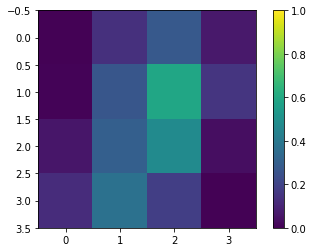

In [5]:
print(train_data[0][1])
plt.imshow(train_data[0][0][0].numpy(), vmin=0, vmax=1); plt.colorbar()

In [6]:
# From TFQ.
def remove_contradicting(dataset):
    mapping = collections.defaultdict(set)
    # Determine the set of labels for each unique image:
    for x, y in dataset:
        mapping[tuple(x.flatten().numpy())].add(int(y))
    
    new_x = []
    new_y = []
    for x, y in dataset:
        labels = mapping[tuple(x.flatten().numpy())]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(list(labels)[0])
        else:
            # Throw out images that match more than one label.
            pass
    
    num_3 = sum(1 for value in mapping.values() if 3 in value or 1 in value)
    num_6 = sum(1 for value in mapping.values() if 6 in value or -1 in value)
    num_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of 3s: ", num_3)
    print("Number of 6s: ", num_6)
    print("Number of contradictory images: ", num_both)
    print()
    print("Initial number of examples: ", len(dataset))
    print("Remaining non-contradictory examples: ", len(new_x))
    
    #return new_x, new_y

In [7]:
remove_contradicting(train_data)

Number of unique images: 12049
Number of 3s:  6131
Number of 6s:  5918
Number of contradictory images:  0

Initial number of examples:  12049
Remaining non-contradictory examples:  12049


In [8]:
THRESHOLD = 0.2
train_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in train_data]), torch.tensor([1 if y == 3 else -1 for _, y in train_data]))
test_data_bin = torch.utils.data.TensorDataset(torch.cat([x > THRESHOLD for x, _ in test_data]), torch.tensor([1 if y == 3 else -1 for _, y in test_data]))

In [9]:
remove_contradicting(train_data_bin)

Number of unique images: 315
Number of 3s:  215
Number of 6s:  154
Number of contradictory images:  54

Initial number of examples:  12049
Remaining non-contradictory examples:  4613


In [10]:
def model_circuit(image, params):
    bits = tuple(image.detach().reshape(-1).numpy().nonzero()[0])
    c = Circuit()
    if bits:
        c.x[bits]
    c.x[16].h[16]
    params = tuple(params.detach().numpy())
    for i in range(16):
        c.rxx(params[i])[16, i]
    for i in range(16):
        c.rzz(params[i + 16])[16, i]
    c.h[16]
    return c

model_readout = Z[16]

In [11]:
# model_circuit(train_data_bin[0][0], torch.ones(32)).run_with_ibmq(returns='draw')

In [12]:
class GeneralFunctionWithForwardDifference(torch.autograd.Function):
    @staticmethod
    def forward(ctx, f, xs, weight):
        def f_each(x, weight):
            return torch.tensor([f(x, weight) for x in xs], dtype=torch.float64)
        ys = f_each(xs, weight)
        ctx.save_for_backward(xs, ys, weight)
        ctx.f = f_each
        return ys
        
    @staticmethod
    def backward(ctx, grad_output):
        xs, ys, weight = ctx.saved_tensors
        dw = 0.001
        diff = []
        weight = weight.detach()
        for i in range(len(weight)):
            weight[i] += dw
            diff.append(torch.sum(grad_output * (ctx.f(xs, weight) - ys)))
            weight[i] -= dw
        diff = torch.tensor(diff) / dw
        #print("grad_output", grad_output, "end")
        #print(diff)
        return None, None, diff

In [13]:
from blueqat.vqe import sparse_expectation

class PQC(torch.nn.Module):
    def __init__(self, model_circuit, n_params, n_qubits, readout_operators, initial_circuit=None):
        super(PQC, self).__init__()
        if initial_circuit is None:
            initial_circuit = Circuit()
        initial_circuit.make_cache()
        self.initial_circuit = initial_circuit
        self.model_circuit = model_circuit
        self.readout_operators = readout_operators
        self.sparses = [op.to_matrix(n_qubits=n_qubits, sparse='csc') for op in readout_operators]
        self.weight = torch.nn.parameter.Parameter(torch.Tensor(n_params))
        torch.nn.init.uniform_(self.weight, 0.0, 2 * np.pi)
        
    def forward(self, x):
        def f(x, weight):
            c = self.initial_circuit.copy()
            c += self.model_circuit(x, self.weight)
            v = c.run()
            return [sparse_expectation(sparse, v) for sparse in self.sparses]
        return GeneralFunctionWithForwardDifference.apply(f, x, self.weight)

In [14]:
class HingeLoss(torch.nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
        self.loss = torch.nn.MarginRankingLoss(margin=1.)

    def forward(self, x, y):
        zeros = torch.zeros_like(x)
        return self.loss(x, zeros, y)

In [15]:
def accuracy(xs, ys):
    xs = xs.detach()
    xs = xs > 0.
    ys = ys > 0.
    return torch.mean((xs == ys).float())

In [16]:
import bokeh
import bokeh.io
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
try:
    from bokeh.io import gridplot
except ImportError:
    from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

In [17]:
epochs = 3
batch_size = 32
x_range_max = len(train_data_bin) // batch_size + 2

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [18]:
from blueqat import BlueqatGlobalSetting
BlueqatGlobalSetting.set_default_backend('numba')

model = PQC(model_circuit, 32, 17, [model_readout])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = HingeLoss()

train_loader = torch.utils.data.DataLoader(train_data_bin, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    model.train()
    losses = []
    for im, label in train_loader:
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out, label)
        update(i, float(torch.mean(loss.detach()).item()), float(acc.item()))
        i += 1
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    model.eval()
    losses = []
    for im, label in test_loader:
        out = model(im)
        out = out.reshape(-1).float()
        loss = criterion(out, label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())
    
    update(epoch, losshist_train[-1], losshist_test[-1])

0 0.999436616897583 0.5625
1 1.0115152597427368 0.3125
2 0.9964292049407959 0.625
3 1.016007661819458 0.34375
4 1.0027940273284912 0.5
5 1.00009024143219 0.5
6 1.003643274307251 0.46875
7 1.0118650197982788 0.34375
8 0.9965304136276245 0.5625
9 0.999292254447937 0.4375
10 1.0091323852539062 0.4375
11 0.9977298378944397 0.53125
12 0.9966436624526978 0.53125
13 0.9918951988220215 0.59375
14 1.0076667070388794 0.4375
15 1.0116337537765503 0.34375
16 1.0046753883361816 0.4375
17 0.9929178357124329 0.53125
18 1.0055410861968994 0.40625
19 0.991608738899231 0.625
20 0.9941167831420898 0.5625
21 1.0001075267791748 0.46875
22 0.9886913895606995 0.65625
23 1.0028774738311768 0.5
24 0.9974392056465149 0.53125
25 0.9853752851486206 0.6875
26 0.9962822198867798 0.5
27 1.0040762424468994 0.375
28 0.9832597374916077 0.65625
29 1.0003993511199951 0.40625
30 0.998602569103241 0.53125
31 0.9964919090270996 0.59375
32 0.9932280778884888 0.59375
33 1.0035876035690308 0.4375
34 0.9815431833267212 0.75
35 

277 0.9248735308647156 0.6875
278 0.9208461046218872 0.71875
279 0.9718703031539917 0.53125
280 0.9541388750076294 0.59375
281 0.95859694480896 0.625
282 0.9029541015625 0.75
283 0.9375611543655396 0.59375
284 0.8819055557250977 0.78125
285 0.9951453804969788 0.625
286 0.8909173011779785 0.78125
287 0.974022388458252 0.625
288 0.9907951354980469 0.53125
289 0.9724798202514648 0.53125
290 0.9397760033607483 0.5625
291 0.9404897093772888 0.65625
292 0.918721079826355 0.625
293 0.9599018096923828 0.625
294 0.8446696400642395 0.8125
295 0.9272506833076477 0.625
296 0.9187508225440979 0.71875
297 0.9286842942237854 0.71875
298 0.920071542263031 0.59375
299 0.9154295325279236 0.625
300 0.9031133055686951 0.71875
301 0.8797606229782104 0.6875
302 0.8402235507965088 0.78125
303 0.9672361612319946 0.59375
304 0.8923856616020203 0.6875
305 0.8673146963119507 0.78125
306 0.9387677907943726 0.65625
307 0.8638840913772583 0.75
308 0.9216402769088745 0.59375
309 0.8723031282424927 0.71875
310 0.8738

549 0.7334151268005371 0.75
550 0.6830455660820007 0.78125
551 0.6445409655570984 0.8125
552 0.8084322214126587 0.65625
553 0.6218554377555847 0.84375
554 0.7570863366127014 0.71875
555 0.8015259504318237 0.6875
556 0.7242734432220459 0.75
557 0.6886368989944458 0.75
558 0.6082654595375061 0.75
559 0.607125461101532 0.84375
560 0.8424093723297119 0.65625
561 0.5389877557754517 0.9375
562 0.7270273566246033 0.6875
563 0.6351664066314697 0.75
564 0.7698544263839722 0.65625
565 0.6297275424003601 0.78125
566 0.724473237991333 0.71875
567 0.6993451118469238 0.71875
568 0.8313693404197693 0.625
569 0.588103175163269 0.8125
570 0.7425567507743835 0.71875
571 0.6048324704170227 0.8125
572 0.6635841727256775 0.78125
573 0.5776990652084351 0.8125
574 0.647891104221344 0.8125
575 0.8342945575714111 0.625
576 0.7900404930114746 0.6875
577 0.509448766708374 0.90625
578 0.7137302756309509 0.65625
579 0.6840658187866211 0.75
580 0.7093026638031006 0.71875
581 0.6997619867324829 0.6875
582 0.64415043

820 0.43140244483947754 0.8125
821 0.6790886521339417 0.71875
822 0.43342041969299316 0.84375
823 0.7577149271965027 0.65625
824 0.40547919273376465 0.84375
825 0.5521819591522217 0.78125
826 0.5081496238708496 0.8125
827 0.5736093521118164 0.78125
828 0.4853011965751648 0.84375
829 0.5467707514762878 0.78125
830 0.4549841284751892 0.84375
831 0.382224977016449 0.90625
832 0.42547693848609924 0.84375
833 0.41197311878204346 0.875
834 0.4280915856361389 0.84375
835 0.6719977259635925 0.71875
836 0.5011102557182312 0.84375
837 0.5260888934135437 0.78125
838 0.4514944553375244 0.84375
839 0.5804779529571533 0.78125
840 0.5570158958435059 0.75
841 0.4464941620826721 0.84375
842 0.5714831948280334 0.75
843 0.5822097659111023 0.78125
844 0.6705409288406372 0.71875
845 0.44284433126449585 0.84375
846 0.4703153371810913 0.8125
847 0.6073602437973022 0.75
848 0.39622801542282104 0.84375
849 0.37617528438568115 0.875
850 0.6031773686408997 0.75
851 0.5970768332481384 0.8125
852 0.707135260105133

1087 0.388488233089447 0.875
1088 0.4012982249259949 0.875
1089 0.5097322463989258 0.75
1090 0.21835589408874512 0.9375
1091 0.4680403172969818 0.75
1092 0.3871003985404968 0.8125
1093 0.3050479590892792 0.875
1094 0.35436153411865234 0.84375
1095 0.4183909595012665 0.8125
1096 0.2911701202392578 0.9375
1097 0.43555963039398193 0.84375
1098 0.3664703071117401 0.90625
1099 0.5705870389938354 0.75
1100 0.30624067783355713 0.875
1101 0.39144688844680786 0.875
1102 0.38360631465911865 0.78125
1103 0.3564055860042572 0.90625
1104 0.4301019012928009 0.875
1105 0.4363088011741638 0.8125
1106 0.3077564239501953 0.90625
1107 0.4457959234714508 0.84375
1108 0.3583904206752777 0.875
1109 0.3415098488330841 0.90625
1110 0.4700727164745331 0.78125
1111 0.5374082922935486 0.78125
1112 0.4677067697048187 0.875
1113 0.2616370916366577 0.9375
1114 0.5145341157913208 0.78125
1115 0.1991698145866394 0.96875
1116 0.39733532071113586 0.78125
1117 0.5415828824043274 0.75
1118 0.4143376648426056 0.84375
1119

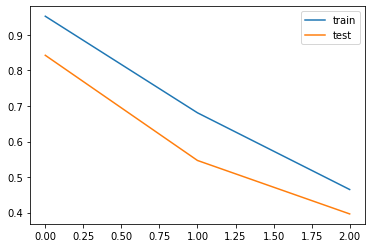

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(losshist_train, label='train')
plt.plot(losshist_test, label='test')
plt.legend()

In [20]:
torch.save(model.state_dict(), 'mnist.pytorch')

In [ ]:
count = 0; tot = 0
for im, label in test_loader:
    model.eval()
    out = model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class ClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 8)
        self.fc2 = torch.nn.Linear(8, 4)
        self.fc3 = torch.nn.Linear(4, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = relu(self.fc2(x))
        x = tanh(self.fc3(x))
        return x

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
relu = torch.nn.functional.relu
tanh = torch.nn.functional.tanh
class TinyClassicalModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(16, 2)
        self.fc2 = torch.nn.Linear(2, 1)
    def forward(self, x):
        x = x.reshape(-1, 16)
        x = relu(self.fc1(x.float()))
        x = tanh(self.fc2(x.float()))
        return x

In [ ]:
tiny_model = TinyClassicalModel()
sum(p.numel() for p in tiny_model.parameters())

In [ ]:
epochs = 3
c_batch_size = 32
x_range_max = epochs + 1

p = figure(title="Loss", plot_height=300, plot_width=350, y_range=(0, 1.0), x_range=(-1, x_range_max))
r_train = p.line([], [], color="red", line_width=2)
r_test = p.line([], [], color="blue", line_width=2)
show(p, notebook_handle=True) 

def update(epoch, d1, d2):
    print(epoch, d1, d2)
    r_train.data_source.stream({'x': [epoch], 'y': [d1]})
    r_test.data_source.stream({'x': [epoch], 'y': [d2]})
    push_notebook()

In [ ]:
optimizer = torch.optim.Adam(tiny_model.parameters(), lr=0.02)
criterion = HingeLoss()

train_loader = torch.utils.data.DataLoader(train_data_bin, batch_size=c_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data_bin)

losshist_train = []; losshist_test = []
i = 0
for epoch in range(epochs):
    tiny_model.train()
    losses = []; acces = []
    for im, label in train_loader:
        out = tiny_model(im)
        #print(out)
        loss = criterion(out.reshape(-1), label)
        losses.append(float(loss.detach()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = accuracy(out.reshape(-1), label)
        acces.append(float(acc))
        i += 1
    update(epoch, float(torch.mean(torch.tensor(losses))),\
           float(torch.mean(torch.tensor(acces))))
    losshist_train.append(torch.mean(torch.tensor(losses)).item())
    
    tiny_model.eval()
    losses = []
    for im, label in test_loader:
        out = tiny_model(im)
        loss = criterion(out.reshape(-1), label)
        losses.append(loss.detach())
    losshist_test.append(torch.mean(torch.tensor(losses)).item())

In [ ]:
count = 0; tot = 0
for im, label in test_loader:
    tiny_model.eval()
    out = tiny_model(im)
    if (out.item() > 0.5) == (label.item() > 0.5):
        count += 1
    tot += 1
print(f'Test result: {count}/{tot} ({100 * count / tot} %)')